download data 

In [1]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
!pip install --force-reinstall --no-deps kaggle
!kaggle -v

     |████████████████████████████████| 61kB 3.3MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=d0d3f76ba517382ea2dad2df1cb0e2e2eef41569157a5753cf6634f51da31ecf
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
Kaggle API 1.5.12


In [3]:
!mkdir /content/data
!kaggle competitions download -c cassava-leaf-disease-classification -p /content/data
!mkdir /content/data/cassava-leaf-disease-classification
!unzip '/content/data/*.zip' -d /content/data/cassava-leaf-disease-classification

ストリーミング出力は最後の 5000 行に切り捨てられました。
  inflating: /content/data/cassava-leaf-disease-classification/train_images/3954399974.jpg  
  inflating: /content/data/cassava-leaf-disease-classification/train_images/3954487465.jpg  
  inflating: /content/data/cassava-leaf-disease-classification/train_images/3954910918.jpg  
  inflating: /content/data/cassava-leaf-disease-classification/train_images/3955391972.jpg  
  inflating: /content/data/cassava-leaf-disease-classification/train_images/3955442838.jpg  
  inflating: /content/data/cassava-leaf-disease-classification/train_images/3955739563.jpg  
  inflating: /content/data/cassava-leaf-disease-classification/train_images/3955931830.jpg  
  inflating: /content/data/cassava-leaf-disease-classification/train_images/3955972139.jpg  
  inflating: /content/data/cassava-leaf-disease-classification/train_images/3956075690.jpg  
  inflating: /content/data/cassava-leaf-disease-classification/train_images/3956077728.jpg  
  inflating: /content/data/cassava-lea

EDA

In [4]:
!pip install timm

     |████████████████████████████████| 348kB 4.3MB/s 


In [21]:
!pip install albumentations==0.4.5

     |████████████████████████████████| 122kB 4.3MB/s 
     |████████████████████████████████| 634kB 27.6MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp37-none-any.whl size=64394 sha256=000c4793e464bfbc3df36aa45541521e1c866b5ad119b85cc701f6f95d5d7936
  Stored in directory: /root/.cache/pip/wheels/f0/a0/61/e50f93165a5ec7e7f5d65064e513239505bc4c06d2289557d3
  Created wheel for imgaug: filename=imgaug-0.2.6-cp37-none-any.whl size=654019 sha256=441358e216e2b52821ccb33a244bcdc874797652c1bdddfa1a20a97dece02402
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [5]:
!mkdir /content/package
!kaggle datasets download -d khyeh0719/image-fmix -p /content/package

  0% 0.00/984k [00:00<?, ?B/s]
100% 984k/984k [00:00<00:00, 157MB/s]


In [6]:
!mkdir /content/package/image-fmix
!unzip /content/package/image-fmix.zip -d /content/package/image-fmix

Archive:  /content/package/image-fmix.zip
  inflating: /content/package/image-fmix/FMix-master/.gitignore  
  inflating: /content/package/image-fmix/FMix-master/LICENSE  
  inflating: /content/package/image-fmix/FMix-master/README.md  
  inflating: /content/package/image-fmix/FMix-master/analysis/README.md  
  inflating: /content/package/image-fmix/FMix-master/analysis/adversarial_linf.py  
  inflating: /content/package/image-fmix/FMix-master/analysis/mine.py  
  inflating: /content/package/image-fmix/FMix-master/analysis/train_vaes.py  
  inflating: /content/package/image-fmix/FMix-master/analysis/vae.py  
  inflating: /content/package/image-fmix/FMix-master/analysis/vae_mi.py  
  inflating: /content/package/image-fmix/FMix-master/analysis/vgg.py  
  inflating: /content/package/image-fmix/FMix-master/datasets/__init__.py  
  inflating: /content/package/image-fmix/FMix-master/datasets/bengali.py  
  inflating: /content/package/image-fmix/FMix-master/datasets/datasets.py  
  inflating: 

In [1]:
package_path = '/content/package/image-fmix/FMix-master'
import sys; sys.path.append(package_path)
from fmix import sample_mask, make_low_freq_image, binarise_mask

In [2]:
from glob import glob
from sklearn.model_selection import GroupKFold, StratifiedKFold
import cv2
from skimage import io
import os
from datetime import datetime
import time
import random
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torchvision import transforms 
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.cuda.amp import autocast, GradScaler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F

import timm

import sklearn 
import warnings
import joblib
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
from scipy.ndimage.interpolation import zoom

In [3]:
DATA_PATH = "/content/data/cassava-leaf-disease-classification"
TRAIN_PATH = os.path.join(DATA_PATH, "train_images")
TEST_PATH = os.path.join(DATA_PATH, "test_images")

In [4]:
CFG = {
    'fold_num': 5,
    'seed': 719,
    'model_arch': 'tf_efficientnet_b4_ns',
    'img_size': 512,
    'epochs': 10,
    'train_bs': 16,
    'valid_bs': 32,
    'T_0': 10,
    'lr': 1e-4,
    'min_lr': 1e-6,
    'weight_decay': 1e-6,
    'num_workers': 4,
    'accum_iter': 2,
    'verbose_step': 1,
    'device': 'cuda:0',
}

In [5]:
train = pd.read_csv(os.path.join(DATA_PATH, "train.csv"))
train.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21397 entries, 0 to 21396
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  21397 non-null  object
 1   label     21397 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 334.5+ KB


In [7]:
train.label.value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

In [8]:
submission = pd.read_csv(os.path.join(DATA_PATH, "sample_submission.csv"))
submission.head()

,image_id,label
0,2216849948.jpg,4


In [9]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

def get_img(path):
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    return im_rgb

In [10]:
import json

with open(os.path.join(DATA_PATH, 'label_num_to_disease_map.json')) as f:
    map = json.load(f)

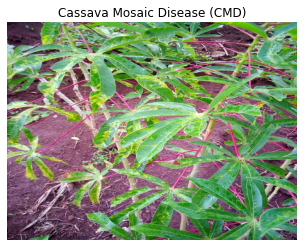

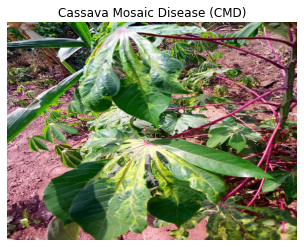

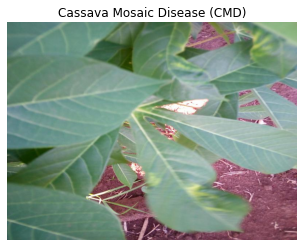

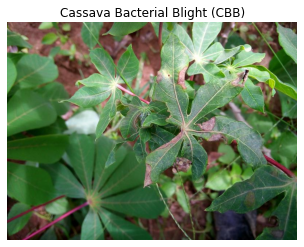

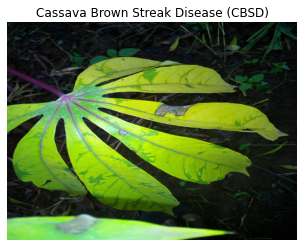

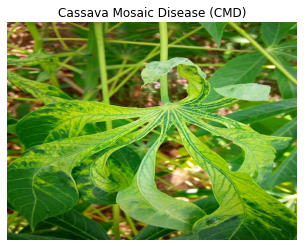

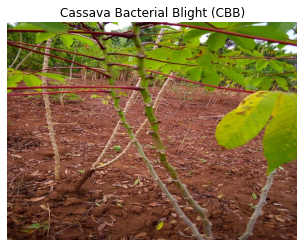

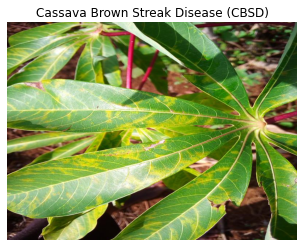

In [14]:
num = 8

for i, row in enumerate(train.sample(n=num).itertuples()):
    img = get_img(os.path.join(TRAIN_PATH, row.image_id))
    plt.title(map[str(row.label)])
    plt.imshow(img)
    plt.axis("off")
    plt.show()

Dataset

In [12]:
def rand_bbox(size, lam):
    W = size[0]
    H = size[1]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2


class CassavaDataset(Dataset):
    def __init__(self, df, data_root, 
                 transforms=None, 
                 output_label=True, 
                 one_hot_label=False,
                 do_fmix=False, 
                 fmix_params={
                     'alpha': 1., 
                     'decay_power': 3., 
                     'shape': (CFG['img_size'], CFG['img_size']),
                     'max_soft': True, 
                     'reformulate': False
                 },
                 do_cutmix=False,
                 cutmix_params={
                     'alpha': 1,
                 }
                ):
        
        super().__init__()
        self.df = df.reset_index(drop=True).copy()
        self.transforms = transforms
        self.data_root = data_root
        self.do_fmix = do_fmix
        self.fmix_params = fmix_params
        self.do_cutmix = do_cutmix
        self.cutmix_params = cutmix_params
        
        self.output_label = output_label
        self.one_hot_label = one_hot_label
        
        if output_label == True:
            self.labels = self.df['label'].values
            #print(self.labels)
            
            if one_hot_label is True:
                self.labels = np.eye(self.df['label'].max()+1)[self.labels]
                #print(self.labels)
            
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index: int):
        
        # get labels
        if self.output_label:
            target = self.labels[index]
          
        img  = get_img("{}/{}".format(self.data_root, self.df.loc[index]['image_id']))

        if self.transforms:
            img = self.transforms(image=img)['image']
        
        if self.do_fmix and np.random.uniform(0., 1., size=1)[0] > 0.5:
            with torch.no_grad():
                #lam, mask = sample_mask(**self.fmix_params)
                
                lam = np.clip(np.random.beta(self.fmix_params['alpha'], self.fmix_params['alpha']),0.6,0.7)
                
                # Make mask, get mean / std
                mask = make_low_freq_image(self.fmix_params['decay_power'], self.fmix_params['shape'])
                mask = binarise_mask(mask, lam, self.fmix_params['shape'], self.fmix_params['max_soft'])
    
                fmix_ix = np.random.choice(self.df.index, size=1)[0]
                fmix_img  = get_img("{}/{}".format(self.data_root, self.df.iloc[fmix_ix]['image_id']))

                if self.transforms:
                    fmix_img = self.transforms(image=fmix_img)['image']

                mask_torch = torch.from_numpy(mask)
                
                # mix image
                img = mask_torch*img+(1.-mask_torch)*fmix_img

                #print(mask.shape)

                #assert self.output_label==True and self.one_hot_label==True

                # mix target
                rate = mask.sum()/CFG['img_size']/CFG['img_size']
                target = rate*target + (1.-rate)*self.labels[fmix_ix]
                #print(target, mask, img)
                #assert False
        
        if self.do_cutmix and np.random.uniform(0., 1., size=1)[0] > 0.5:
            #print(img.sum(), img.shape)
            with torch.no_grad():
                cmix_ix = np.random.choice(self.df.index, size=1)[0]
                cmix_img  = get_img("{}/{}".format(self.data_root, self.df.iloc[cmix_ix]['image_id']))
                if self.transforms:
                    cmix_img = self.transforms(image=cmix_img)['image']
                    
                lam = np.clip(np.random.beta(self.cutmix_params['alpha'], self.cutmix_params['alpha']),0.3,0.4)
                bbx1, bby1, bbx2, bby2 = rand_bbox((CFG['img_size'], CFG['img_size']), lam)

                img[:, bbx1:bbx2, bby1:bby2] = cmix_img[:, bbx1:bbx2, bby1:bby2]

                rate = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (CFG['img_size'] * CFG['img_size']))
                target = rate*target + (1.-rate)*self.labels[cmix_ix]
                
            #print('-', img.sum())
            #print(target)
            #assert False
                            
        # do label smoothing
        #print(type(img), type(target))
        if self.output_label == True:
            return img, target
        else:
            return img

Augumentation

In [13]:
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize
)

from albumentations.pytorch import ToTensorV2

def get_train_transforms():
    return Compose([
            RandomResizedCrop(CFG['img_size'], CFG['img_size']),
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            CoarseDropout(p=0.5),
            Cutout(p=0.5),
            ToTensorV2(p=1.0),
        ], p=1.)
  
        
def get_valid_transforms():
    return Compose([
            CenterCrop(CFG['img_size'], CFG['img_size'], p=1.),
            Resize(CFG['img_size'], CFG['img_size']),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)

Model

In [55]:
class CassavaImgClassifier(nn.Module):
    def __init__(self, model_arch, n_class, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, n_class)
        '''
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.3),
            #nn.Linear(n_features, hidden_size,bias=True), nn.ELU(),
            nn.Linear(n_features, n_class, bias=True)
        )
        '''
    def forward(self, x):
        x = self.model(x)
        return x

Training API

In [19]:
!pip install catalyst

     |████████████████████████████████| 522kB 4.2MB/s 
     |████████████████████████████████| 645kB 37.1MB/s 
     |████████████████████████████████| 122kB 56.9MB/s 
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [56]:
from catalyst.data.sampler import BalanceClassSampler
from tqdm.notebook import tqdm

def prepare_dataloader(df, trn_idx, val_idx, data_root=TRAIN_PATH):
    
    train_ = df.loc[trn_idx,:].reset_index(drop=True)
    valid_ = df.loc[val_idx,:].reset_index(drop=True)
        
    train_ds = CassavaDataset(train_, data_root, transforms=get_train_transforms(), output_label=True, one_hot_label=False, do_fmix=False, do_cutmix=False)
    valid_ds = CassavaDataset(valid_, data_root, transforms=get_valid_transforms(), output_label=True)
    
    train_loader = torch.utils.data.DataLoader(
        train_ds,
        batch_size=CFG['train_bs'],
        pin_memory=False,
        drop_last=False,
        shuffle=True,        
        num_workers=CFG['num_workers'],
        #sampler=BalanceClassSampler(labels=train_['label'].values, mode="downsampling")
    )
    val_loader = torch.utils.data.DataLoader(
        valid_ds, 
        batch_size=CFG['valid_bs'],
        num_workers=CFG['num_workers'],
        shuffle=False,
        pin_memory=False,
    )
    return train_loader, val_loader

def train_one_epoch(epoch, model, loss_fn, optimizer, train_loader, device, scheduler=None, schd_batch_update=False):
    model.train()

    t = time.time()
    running_loss = None

    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()

        #print(image_labels.shape, exam_label.shape)
        with autocast():
            image_preds = model(imgs)   #output = model(input)
            #print(image_preds.shape, exam_pred.shape)

            loss = loss_fn(image_preds, image_labels)
            
            scaler.scale(loss).backward()

            if running_loss is None:
                running_loss = loss.item()
            else:
                running_loss = running_loss * .99 + loss.item() * .01

            if ((step + 1) %  CFG['accum_iter'] == 0) or ((step + 1) == len(train_loader)):
                # may unscale_ here if desired (e.g., to allow clipping unscaled gradients)

                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad() 
                
                if scheduler is not None and schd_batch_update:
                    scheduler.step()

            if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(train_loader)):
                description = f'epoch {epoch} loss: {running_loss:.4f}'
                
                pbar.set_description(description)
                
    if scheduler is not None and not schd_batch_update:
        scheduler.step()
        
def valid_one_epoch(epoch, model, loss_fn, val_loader, device, scheduler=None, schd_loss_update=False):
    model.eval()

    t = time.time()
    loss_sum = 0
    sample_num = 0
    image_preds_all = []
    image_targets_all = []
    
    pbar = tqdm(enumerate(val_loader), total=len(val_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()
        
        image_preds = model(imgs)   #output = model(input)
        #print(image_preds.shape, exam_pred.shape)
        image_preds_all += [torch.argmax(image_preds, 1).detach().cpu().numpy()]
        image_targets_all += [image_labels.detach().cpu().numpy()]
        
        loss = loss_fn(image_preds, image_labels)
        
        loss_sum += loss.item()*image_labels.shape[0]
        sample_num += image_labels.shape[0]  

        if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(val_loader)):
            description = f'epoch {epoch} loss: {loss_sum/sample_num:.4f}'
            pbar.set_description(description)
    
    image_preds_all = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    print('validation multi-class accuracy = {:.4f}'.format((image_preds_all==image_targets_all).mean()))
    
    if scheduler is not None:
        if schd_loss_update:
            scheduler.step(loss_sum/sample_num)
        else:
            scheduler.step()

In [17]:
class MyCrossEntropyLoss(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean'):
        super().__init__(weight=weight, reduction=reduction)
        self.weight = weight
        self.reduction = reduction

    def forward(self, inputs, targets):
        lsm = F.log_softmax(inputs, -1)

        if self.weight is not None:
            lsm = lsm * self.weight.unsqueeze(0)

        loss = -(targets * lsm).sum(-1)

        if  self.reduction == 'sum':
            loss = loss.sum()
        elif  self.reduction == 'mean':
            loss = loss.mean()

        return loss

Train Loop

In [57]:
if __name__ == '__main__':
     # for training only, need nightly build pytorch

    seed_everything(CFG['seed'])
    
    folds = StratifiedKFold(n_splits=CFG['fold_num'], shuffle=True, random_state=CFG['seed']).split(np.arange(train.shape[0]), train.label.values)
    
    for fold, (trn_idx, val_idx) in enumerate(folds):
        # we'll train fold 0 first
        if fold > 0:
            break 

        print('Training with {} started'.format(fold))

        print(len(trn_idx), len(val_idx))
        train_loader, val_loader = prepare_dataloader(train, trn_idx, val_idx, data_root=TRAIN_PATH)

        device = torch.device(CFG['device'])
        
        model = CassavaImgClassifier(CFG['model_arch'], train.label.nunique(), pretrained=True).to(device)
        scaler = GradScaler()   
        optimizer = torch.optim.Adam(model.parameters(), lr=CFG['lr'], weight_decay=CFG['weight_decay'])
        #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=CFG['epochs']-1)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=CFG['T_0'], T_mult=1, eta_min=CFG['min_lr'], last_epoch=-1)
        #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=25, 
        #                                                max_lr=CFG['lr'], epochs=CFG['epochs'], steps_per_epoch=len(train_loader))
        
        loss_tr = nn.CrossEntropyLoss().to(device) #MyCrossEntropyLoss().to(device)
        loss_fn = nn.CrossEntropyLoss().to(device)
        
        for epoch in range(CFG['epochs']):
            train_one_epoch(epoch, model, loss_tr, optimizer, train_loader, device, scheduler=scheduler, schd_batch_update=False)

            with torch.no_grad():
                valid_one_epoch(epoch, model, loss_fn, val_loader, device, scheduler=None, schd_loss_update=False)

            torch.save(model.state_dict(),'/content/drive/MyDrive/kaggle/Cassava/model_weight/{}_fold_{}_{}'.format(CFG['model_arch'], fold, epoch))
            
        #torch.save(model.cnn_model.state_dict(),'{}/cnn_model_fold_{}_{}'.format(CFG['model_path'], fold, CFG['tag']))
        del model, optimizer, train_loader, val_loader, scaler, scheduler
        torch.cuda.empty_cache()

Training with 0 started
17117 4280


KeyboardInterrupt: ignored

In [34]:
CFG = {
    'fold_num': 5,
    'seed': 719,
    'model_arch': 'vit_base_patch16_224',
    'img_size': 224,
    'epochs': 10,
    'train_bs': 16,
    'valid_bs': 32,
    'T_0': 10,
    'lr': 1e-4,
    'min_lr': 1e-6,
    'weight_decay': 1e-6,
    'num_workers': 4,
    'accum_iter': 2,
    'verbose_step': 1,
    'device': 'cuda:0',
}

In [58]:
class CassavaImgClassifier_ViT(nn.Module):
    def __init__(self, model_arch, n_class, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained)
        n_features = self.model.head.in_features
        self.model.head = nn.Linear(n_features, n_class)
        '''
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.3),
            #nn.Linear(n_features, hidden_size,bias=True), nn.ELU(),
            nn.Linear(n_features, n_class, bias=True)
        )
        '''
    def forward(self, x):
        x = self.model(x)
        return x

In [35]:
if __name__ == '__main__':
     # for training only, need nightly build pytorch

    seed_everything(CFG['seed'])
    
    folds = StratifiedKFold(n_splits=CFG['fold_num'], shuffle=True, random_state=CFG['seed']).split(np.arange(train.shape[0]), train.label.values)
    
    for fold, (trn_idx, val_idx) in enumerate(folds):
        # we'll train fold 0 first
        if fold > 0:
            break 

        print('Training with {} started'.format(fold))

        print(len(trn_idx), len(val_idx))
        train_loader, val_loader = prepare_dataloader(train, trn_idx, val_idx, data_root=TRAIN_PATH)

        device = torch.device(CFG['device'])
        
        model = CassvaImgClassifier_ViT(CFG['model_arch'], train.label.nunique(), pretrained=True).to(device)
        scaler = GradScaler()   
        optimizer = torch.optim.Adam(model.parameters(), lr=CFG['lr'], weight_decay=CFG['weight_decay'])
        #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=CFG['epochs']-1)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=CFG['T_0'], T_mult=1, eta_min=CFG['min_lr'], last_epoch=-1)
        #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=25, 
        #                                                max_lr=CFG['lr'], epochs=CFG['epochs'], steps_per_epoch=len(train_loader))
        
        loss_tr = nn.CrossEntropyLoss().to(device) #MyCrossEntropyLoss().to(device)
        loss_fn = nn.CrossEntropyLoss().to(device)
        
        for epoch in range(CFG['epochs']):
            train_one_epoch(epoch, model, loss_tr, optimizer, train_loader, device, scheduler=scheduler, schd_batch_update=False)

            with torch.no_grad():
                valid_one_epoch(epoch, model, loss_fn, val_loader, device, scheduler=None, schd_loss_update=False)

            torch.save(model.state_dict(),'/content/drive/MyDrive/kaggle/Cassava/model_weight/{}_fold_{}_{}'.format(CFG['model_arch'], fold, epoch))
            
        #torch.save(model.cnn_model.state_dict(),'{}/cnn_model_fold_{}_{}'.format(CFG['model_path'], fold, CFG['tag']))
        del model, optimizer, train_loader, val_loader, scaler, scheduler
        torch.cuda.empty_cache()

Training with 0 started
17117 4280



validation multi-class accuracy = 0.8325



validation multi-class accuracy = 0.8430



validation multi-class accuracy = 0.8526



validation multi-class accuracy = 0.8388



validation multi-class accuracy = 0.8526



validation multi-class accuracy = 0.8572



validation multi-class accuracy = 0.8610



validation multi-class accuracy = 0.8554



validation multi-class accuracy = 0.8610



validation multi-class accuracy = 0.8666


In [36]:
transforms = get_train_transforms()

6246


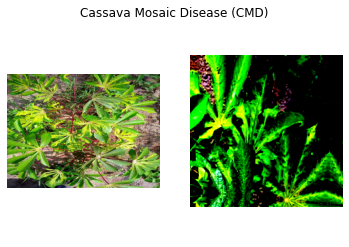

In [47]:
index = int(input())
fig = plt.figure()
plt.axis("off")

img = get_img(os.path.join(TRAIN_PATH, train.loc[index, 'image_id']))
plt.title(map[str(train.loc[index, 'label'])])
ax1 = fig.add_subplot(1, 2, 1)
plt.imshow(img)
plt.axis("off")
plt.show()

img_trans = transforms(image=img)['image']
img_trans = img_trans.numpy().transpose(1, 2, 0)
img_trans = np.clip(img_trans, 0, 1)
ax2 = fig.add_subplot(1, 2, 2)
plt.imshow(img_trans)
plt.axis("off")
plt.show()

In [48]:
CFG = {
    'fold_num': 5,
    'seed': 719,
    'model_arch':  'vit_base_patch16_384',
    'img_size': 384,
    'epochs': 10,
    'train_bs': 16,
    'valid_bs': 32,
    'T_0': 10,
    'lr': 1e-4,
    'min_lr': 1e-6,
    'weight_decay': 1e-6,
    'num_workers': 4,
    'accum_iter': 2,
    'verbose_step': 1,
    'device': 'cuda:0',
}

In [49]:
if __name__ == '__main__':
     # for training only, need nightly build pytorch

    seed_everything(CFG['seed'])
    
    folds = StratifiedKFold(n_splits=CFG['fold_num'], shuffle=True, random_state=CFG['seed']).split(np.arange(train.shape[0]), train.label.values)
    
    for fold, (trn_idx, val_idx) in enumerate(folds):
        # we'll train fold 0 first
        if fold > 0:
            break 

        print('Training with {} started'.format(fold))

        print(len(trn_idx), len(val_idx))
        train_loader, val_loader = prepare_dataloader(train, trn_idx, val_idx, data_root=TRAIN_PATH)

        device = torch.device(CFG['device'])
        
        model = CassvaImgClassifier_ViT(CFG['model_arch'], train.label.nunique(), pretrained=True).to(device)
        scaler = GradScaler()   
        optimizer = torch.optim.Adam(model.parameters(), lr=CFG['lr'], weight_decay=CFG['weight_decay'])
        #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=CFG['epochs']-1)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=CFG['T_0'], T_mult=1, eta_min=CFG['min_lr'], last_epoch=-1)
        #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=25, 
        #                                                max_lr=CFG['lr'], epochs=CFG['epochs'], steps_per_epoch=len(train_loader))
        
        loss_tr = nn.CrossEntropyLoss().to(device) #MyCrossEntropyLoss().to(device)
        loss_fn = nn.CrossEntropyLoss().to(device)
        
        for epoch in range(CFG['epochs']):
            train_one_epoch(epoch, model, loss_tr, optimizer, train_loader, device, scheduler=scheduler, schd_batch_update=False)

            with torch.no_grad():
                valid_one_epoch(epoch, model, loss_fn, val_loader, device, scheduler=None, schd_loss_update=False)

            torch.save(model.state_dict(),'/content/drive/MyDrive/kaggle/Cassava/model_weight/{}_fold_{}_{}'.format(CFG['model_arch'], fold, epoch))
            
        #torch.save(model.cnn_model.state_dict(),'{}/cnn_model_fold_{}_{}'.format(CFG['model_path'], fold, CFG['tag']))
        del model, optimizer, train_loader, val_loader, scaler, scheduler
        torch.cuda.empty_cache()

Training with 0 started
17117 4280


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_p16_384-83fb41ba.pth" to /root/.cache/torch/hub/checkpoints/jx_vit_base_p16_384-83fb41ba.pth



validation multi-class accuracy = 0.8432



validation multi-class accuracy = 0.8752



validation multi-class accuracy = 0.8731



validation multi-class accuracy = 0.8738



validation multi-class accuracy = 0.8764



validation multi-class accuracy = 0.8778



validation multi-class accuracy = 0.8794



validation multi-class accuracy = 0.8783



validation multi-class accuracy = 0.8815



validation multi-class accuracy = 0.8836


In [50]:
MODEL_PATH = "/content/drive/MyDrive/kaggle/Cassava/model_weight"

In [65]:
CFG = {
    'fold_num': 5,
    'seed': 719,
    'model_arch': 'tf_efficientnet_b4_ns',
    'img_size': 512,
    'epochs': 10,
    'train_bs': 16,
    'valid_bs': 32,
    'T_0': 10,
    'lr': 1e-4,
    'min_lr': 1e-6,
    'weight_decay': 1e-6,
    'num_workers': 4,
    'accum_iter': 2,
    'verbose_step': 1,
    'device': 'cuda:0',
    'used_epochs': [6, 7, 8, 9],
    'tta': 3,
    'weights': [1, 1, 1, 1],
    'model': [
              {
                  'model_arch': 'tf_efficientnet_b4_ns',
                  'img_size': 512,
              },
              {
                  'model_arch': 'vit_base_patch16_384',
                  'img_size': 384,
              }
    ]
}

In [59]:
def get_inference_transforms(model_index):
    return  Compose([
                     RandomResizedCrop(CFG['model'][model_index]['img_size'],CFG['model'][model_index]['img_size']),
                     Transpose(p=0.5),
                     HorizontalFlip(p=0.5),
                     VerticalFlip(p=0.5),
                     HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
                     RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
                     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
                     ToTensorV2(p=1.0),                     
    ], p=1.)

In [62]:
def inference_one_epoch(model, data_loader, device):
    model.eval()
    image_preds_all = []
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    for step, (imgs) in pbar:
        imgs = imgs.to(device).float()

        image_preds = model(imgs)
        image_preds_all += [torch.softmax(image_preds, 1).detach().cpu().numpy()]

    image_preds_all = np.concatenate(image_preds_all, axis=0)
    return image_preds_all

In [83]:
if __name__ == '__main__':
    seed_everything(CFG['seed'])

    for fold in range(CFG['fold_num']):
        if fold > 0:
            break

        print('Inference fold {} started'.format(fold))

        test = pd.DataFrame()
        test['image_id'] = list(os.listdir(TEST_PATH))
        test_ds = list()
        tst_loader = list()
        for i in range(2):
            test_ds.append(CassavaDataset(test, TEST_PATH, transforms=get_inference_transforms(i), output_label=False))
            tst_loader.append(torch.utils.data.DataLoader(test_ds[i], batch_size=CFG['valid_bs'], num_workers=CFG['num_workers'], shuffle=False, pin_memory=False))
            
        device = torch.device(CFG['device'])
        model = [
                 CassavaImgClassifier(CFG['model'][0]['model_arch'], train.label.nunique(), pretrained=False).to(device),
                 CassavaImgClassifier_ViT(CFG['model'][1]['model_arch'], train.label.nunique(), pretrained=False).to(device)
        ]

        tst_preds = []

        for i, epoch in enumerate(CFG['used_epochs']):
            model[0].load_state_dict(torch.load(os.path.join(MODEL_PATH, '{}_fold_{}_{}'.format(CFG['model'][0]['model_arch'], fold, epoch))))
            model[1].load_state_dict(torch.load(os.path.join(MODEL_PATH, '{}_fold_{}_{}'.format(CFG['model'][1]['model_arch'], fold, epoch))))

            with torch.no_grad():
                for _ in range(CFG['tta']):
                    tst_preds += [inference_one_epoch(model[0], tst_loader[0], device)]
                    tst_preds += [inference_one_epoch(model[1], tst_loader[1], device)]


        tst_preds = np.mean(tst_preds, axis=0)

        del model
        torch.cuda.empty_cache()

Inference fold 0 started


In [84]:
tst_preds

array([[0.00985295, 0.03651188, 0.42542198, 0.01844869, 0.5097645 ]],
      dtype=float32)

In [85]:
test['label'] = np.argmax(tst_preds, axis=1)
test.head()

,image_id,label
0,2216849948.jpg,4


In [86]:
test.to_csv('submission_csv', index=False)

upload model weights as dataset

In [87]:
!kaggle datasets version -p /content/drive/MyDrive/kaggle/Cassava/model_weight -m "efficient net + ViT"

Starting upload for file model_5e_20210621-1354.pth
100% 327M/327M [00:27<00:00, 12.5MB/s]
Upload successful: model_5e_20210621-1354.pth (327MB)
Starting upload for file tf_efficientnet_b4_ns_fold_0_0
100% 67.7M/67.7M [00:12<00:00, 5.62MB/s]
Upload successful: tf_efficientnet_b4_ns_fold_0_0 (68MB)
Starting upload for file tf_efficientnet_b4_ns_fold_0_1
100% 67.7M/67.7M [00:15<00:00, 4.72MB/s]
Upload successful: tf_efficientnet_b4_ns_fold_0_1 (68MB)
Starting upload for file tf_efficientnet_b4_ns_fold_0_2
100% 67.7M/67.7M [00:11<00:00, 5.92MB/s]
Upload successful: tf_efficientnet_b4_ns_fold_0_2 (68MB)
Starting upload for file tf_efficientnet_b4_ns_fold_0_3
100% 67.7M/67.7M [00:12<00:00, 5.54MB/s]
Upload successful: tf_efficientnet_b4_ns_fold_0_3 (68MB)
Starting upload for file tf_efficientnet_b4_ns_fold_0_4
100% 67.7M/67.7M [00:13<00:00, 5.33MB/s]
Upload successful: tf_efficientnet_b4_ns_fold_0_4 (68MB)
Starting upload for file tf_efficientnet_b4_ns_fold_0_5
100% 67.7M/67.7M [00:13<00:00